# Framingham Heart Disease Risk Study
 ## Exploratory Data Analysis

## 1. Sourcing and loading

### 1.1 Import libraries

In [144]:
# Working with data
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualization and exploration
import matplotlib.pyplot as plt
import seaborn as sns
# from ydata_profiling import ProfileReport
# from pca import pca

# Modeling
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# QOL things
# !pip install tqdm
from tqdm.notebook import tqdm # Progress bar
tqdm.set_lock(None)  # Disable thread locking to prevent issues in Jupyter notebooks

# Custom functions
from functions import grid_plots, ecdf, get_function_code, sb_utils

### 1.2 Load data

In [145]:
df_drop_path = '../data/interim/data_droped.csv'
df_imputed_path = '../data/interim/data_imputed.csv'

df_imp = pd.read_csv(df_imputed_path)
df = pd.read_csv(df_drop_path)

### 1.3 Exploring data

In [146]:
df.shape, df_imp.shape

((3656, 16), (4238, 16))

As a disclaimer, the 'data_clean' and 'data_winsorized' are practically the same data sets, but within the winsorized data all the extreme outliers were winsorized to fit within the range of (Q1 - 1.5*IQR) and (Q3 + 1.5*IQR). So it will make sense to focus on just 'df_clean' data set for now, and keep the 'df_winsorized' for the future model evaluations.

In [147]:
df.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39          4              0           0       0                0   
1     0   46          2              0           0       0                0   
2     1   48          1              1          20       0                0   
3     0   61          3              1          30       0                0   
4     0   46          3              1          23       0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [148]:
# Convert all int columns to category
df = df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3656 non-null   int64  
 1   age              3656 non-null   int64  
 2   education        3656 non-null   int64  
 3   currentSmoker    3656 non-null   int64  
 4   cigsPerDay       3656 non-null   int64  
 5   BPMeds           3656 non-null   int64  
 6   prevalentStroke  3656 non-null   int64  
 7   prevalentHyp     3656 non-null   int64  
 8   diabetes         3656 non-null   int64  
 9   totChol          3656 non-null   float64
 10  sysBP            3656 non-null   float64
 11  diaBP            3656 non-null   float64
 12  BMI              3656 non-null   float64
 13  heartRate        3656 non-null   float64
 14  glucose          3656 non-null   float64
 15  TenYearCHD       3656 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 457.1 KB


#### Column definitions:
* male: (nominal)
    * 0 for female
    * 1 for male
* age: (continuous)
    * Age of the patient 
* education: (ordinal) (presumably)
    1. Some high school
    2. High school diploma
    3. Some college or vocational training
    4. College degree or higher
* current_smoker: (nominal)
    * 1 - Yes
    * 0 - No 
* cigsPerDay: (continuous)
    * Number of cigarettes smoked each day
* BPMeds: (nominal)
    * 1 if patient takes anti-hypertension medications
    * 0 if patient does not take anti-hypertension medications
* prevalentStroke: (nominal)
    * 1 if patient previously had stroke
    * 0 if patient did not have stroke in the past
* prevalentHyp: (nominal)
    * 1 if patient previously had diagnosed hypertension
    * 0 if patient did not have hypertension in the past
* diabetes: (nominal)
    * 1 if patient has diabetes
    * 0 if patient does not have diabetes
* totChol: (continuous)
    * Total cholesterol concentration (mg/dl)
* sysBP: (continuous)
    * Systolic blood pressure (mmHg)
* diaBP: (continuous)
    * Diastolic blood pressure (mmHg)
* BMI: (continuous)
    * Body Mass Index
* heartRate: (continuous)
    * Heart Rate (bpm)
* glucose: (continuous)
    * Blood glucose concentration (mg/dl)
* TenYearCHD: (nominal) ----> Target
    * 1 if patient has 10 year risk of coronary heart disease (CHD)
    * 0 if patient has no 10 year CHD risk

Let's explore the target value 'TenYearCHD' 

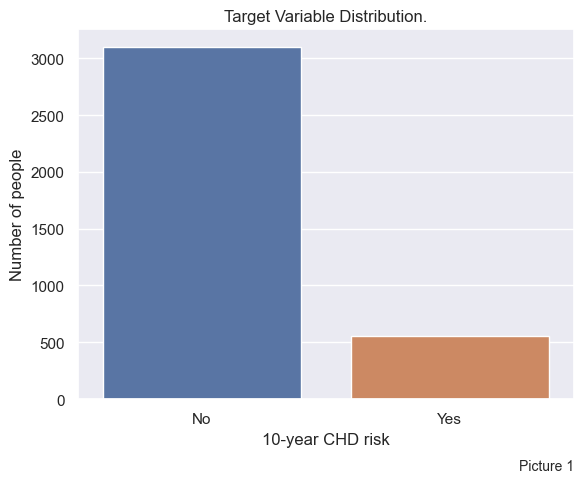

In [149]:
sns.countplot(data=df, x='TenYearCHD')
plt.ylabel('Number of people')
plt.xlabel('10-year CHD risk')
plt.title('Target Variable Distribution.')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
grid_plots.annotate('Picture 1')
plt.show()

In [150]:
df[df['TenYearCHD'] == 0]['TenYearCHD'].count() / df[df['TenYearCHD'] == 1]['TenYearCHD'].count()
# ['TenYearCHD'].sum() / df.shape[0]

5.563734290843806

There is an imbalance within our target value with ratio of 5.6 / 1 (No Risk / Risk). We will balance this in future and compare model performance.

In [151]:
# Define categorical and continuous columns
categorical_cols = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
cont_units = ['years', 'cigs/day', 'mg/dl', 'mmHg', 'mmHg', 'kg/m^2', 'bpm', 'mg/dl']


Let's visualize our columns. Starting with categorical values.

In [152]:
df[categorical_cols] = df[categorical_cols].astype('category')
df[categorical_cols].describe()

male  education  currentSmoker  BPMeds  prevalentStroke  prevalentHyp  \
count   3656       3656           3656    3656             3656          3656   
unique     2          4              2       2                2             2   
top        0          1              0       0                0             0   
freq    2034       1526           1868    3545             3635          2517   

        diabetes  
count       3656  
unique         2  
top            0  
freq        3557

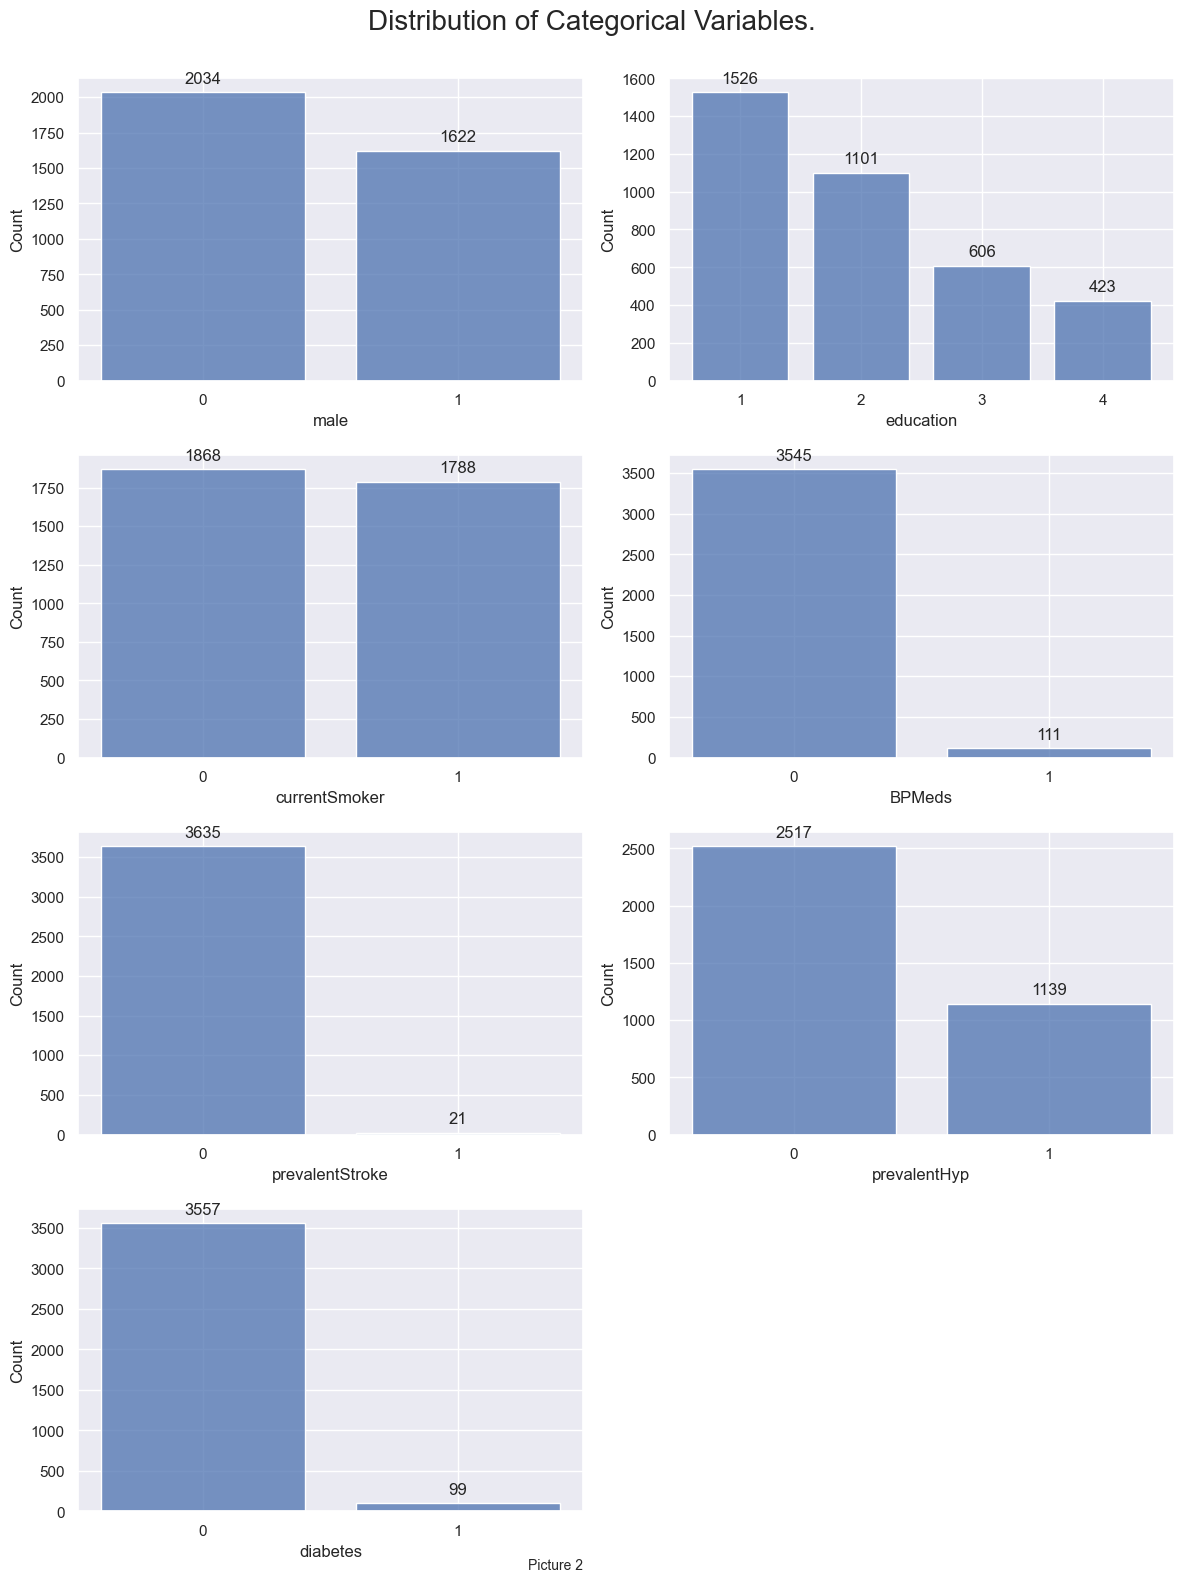

In [153]:
grid_plots.plot_grid_bar(df, categorical_cols, title='Distribution of Categorical Variables.\n', annotation='Picture 2')

We can see that out of all categorical columns the most balanced are 'sex' and 'is_smoking'. 
Education column shows the expected distribution of education levels.
Prevalent hypertension column shows that approximately 1/3 of all patients have diagnosis of hypertension, but only 94! out of them take any blood pressure medications. Compared to the column 'hypertension_calc' that was calculated in previous step, there is not much difference in the diagnosed hypertension distribution.
We will do the same with the diabetes column, comparing it with the blood sugar levels, because there are only 109 patients with established diagnosis of diabetes.
Prevalent stroke column (with only 19 positive patients) cannot be compared with any other column. Although we can look if it's more prevalent in elderly patients, and if this column is of any use.

In [154]:
stroke_ages = df[df['prevalentStroke'] == 1]['age'].value_counts().sort_index().reset_index()['age'].to_list()
# df[continuous_cols].mean()
df.loc[df['age'].isin(stroke_ages)][continuous_cols + ['prevalentStroke']].groupby('prevalentStroke').mean().T

prevalentStroke           0           1
age               52.912414   55.285714
cigsPerDay         8.022087    3.333333
totChol          240.454684  244.238095
sysBP            135.540746  150.119048
diaBP             83.956969   91.714286
BMI               25.918317   27.735238
heartRate         75.692308   73.047619
glucose           83.131759   86.904762

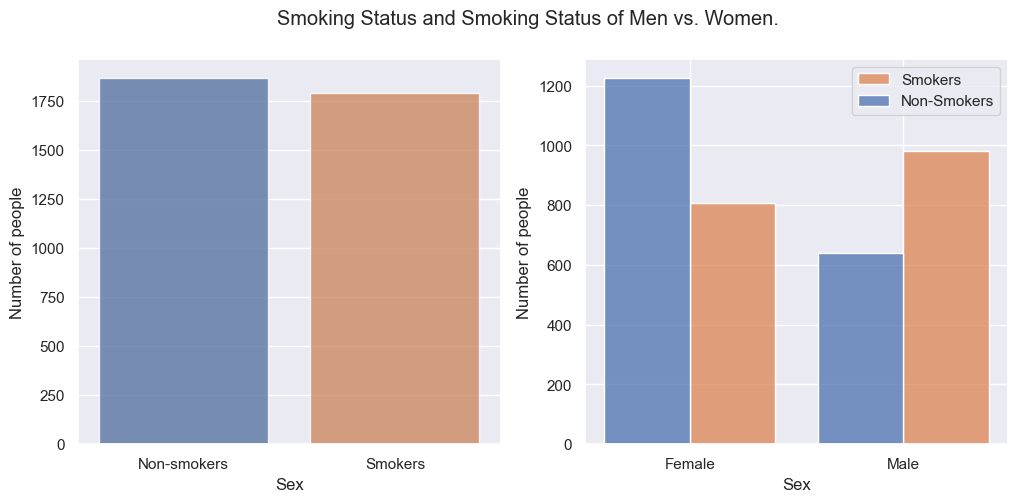

In [155]:
# Plot countplot of currentSmoker column and currentSmoker column by age side by male
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=df, x='currentSmoker', ax=ax[0], alpha=.8)
sns.histplot(data=df, x='male', hue='currentSmoker', ax=ax[1], multiple='dodge', shrink=.8)
ax[0].set_xticklabels(['Non-smokers', 'Smokers'])
ax[0].set_ylabel('Number of people')
ax[0].set_xlabel('Sex')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Female', 'Male'])
ax[1].set_ylabel('Number of people')
ax[1].set_xlabel('Sex')
plt.legend(['Smokers', 'Non-Smokers'])
fig.suptitle('Smoking Status and Smoking Status of Men vs. Women.');

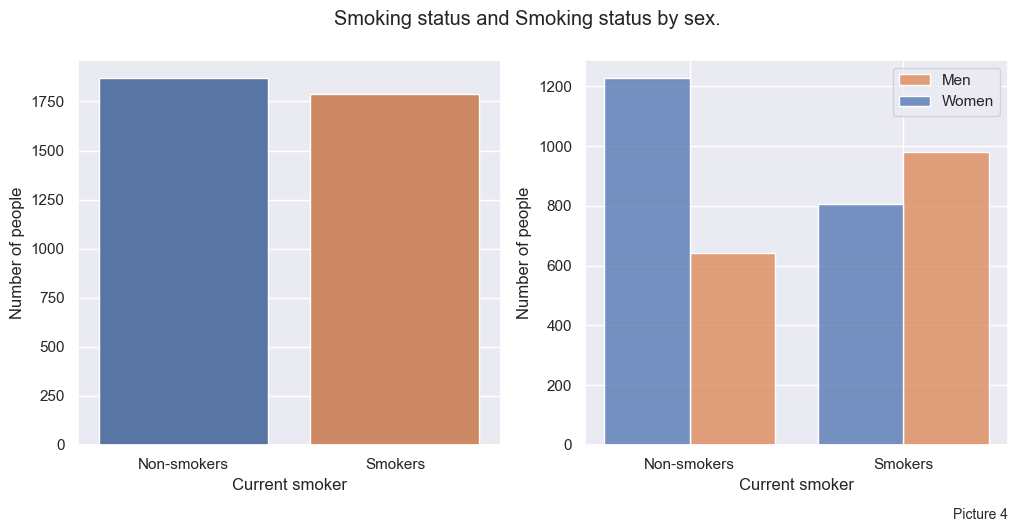

In [156]:
# Plot countplot of currentSmoker column and currentSmoker column by age side by male
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=df, x='currentSmoker', ax=ax[0])
sns.histplot(data=df, x='currentSmoker', hue='male', ax=ax[1], multiple='dodge', shrink=.8)
ax[0].set_xticklabels(['Non-smokers', 'Smokers'])
ax[0].set_ylabel('Number of people')
ax[0].set_xlabel('Current smoker')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Non-smokers', 'Smokers'])
ax[1].set_ylabel('Number of people')
ax[1].set_xlabel('Current smoker')
ax[1].legend_.set_title('Sex')
plt.legend(['Men', 'Women'])
grid_plots.annotate('Picture 4')
fig.suptitle('Smoking status and Smoking status by sex.');

Although the number of smokers and non-smokers is almost equal, there are more men among smokers. Out of curiosity let's see how education related with smoking status in the 1970s.

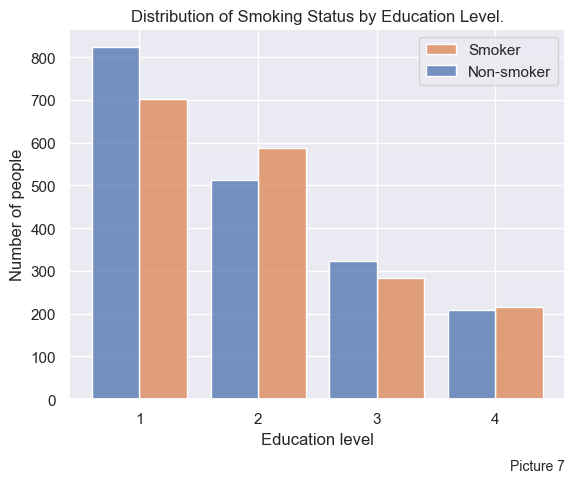

In [157]:
sns.histplot(data=df, x='education', hue='currentSmoker', multiple='dodge', shrink=.8)
plt.ylabel('Number of people')
plt.xlabel('Education level')
plt.xticks(ticks=[1, 2, 3, 4])
plt.title('Distribution of Smoking Status by Education Level.')
plt.legend(['Smoker', 'Non-smoker'])
grid_plots.annotate('Picture 7');

That's interesting! The largest portion of non-smokers is within an education level 1 group. Level 2 shows the opposite pattern, with smokers being more prevalent. Level 3 shows similar ratio as level 1. And there are slightly more smokers than non-smokers in the level 4 group. Could this be related to some other factors?

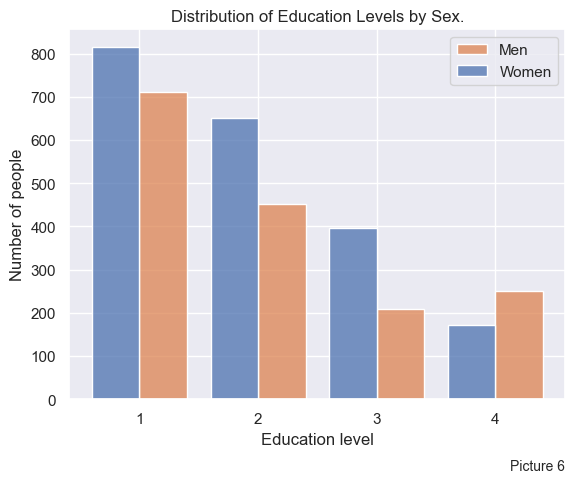

In [158]:
sns.histplot(data=df, x='education', hue='male',  multiple='dodge', shrink=.8, legend=True)
plt.ylabel('Number of people')
plt.xlabel('Education level')
plt.title('Distribution of Education Levels by Sex.')
plt.xticks(ticks=[1, 2, 3, 4])
plt.legend(['Men', 'Women'])
grid_plots.annotate('Picture 6');


It seems like women are more prevalent in level 1-3 education groups, with 2/1 ratio within the level 3 group. 
Comparing absolute values within the groups makes an impression that almost all smokers within level 1 are men (~800), but can we say that there is an influence within other groups, let's check.

In [159]:
# Find a number of people within each education level, sex group and smoking status 
smok_sex_ed = df[['male', 'education', 'currentSmoker']].groupby(['education', 'male', 'currentSmoker']).value_counts()
sex_ed = smok_sex_ed.groupby(['education', 'male']).sum()
sse_percentage = pd.merge(smok_sex_ed, sex_ed, on=['education', 'male'], suffixes=('', '_total')).reset_index()
smok_stat = smok_sex_ed.reset_index()[['currentSmoker', 'count']]
sse_percentage = pd.merge(sse_percentage, smok_stat, on='count')
# Change column order: education, male, currentSmoker, count, count_total
sse_percentage = sse_percentage[['education', 'male', 'currentSmoker', 'count', 'count_total']]
# Count percentage of values in count column by count_total column
sse_percentage['percentage'] = sse_percentage['count'] / sse_percentage['count_total']
# Add comment column with 'Smoking men' or 'Smoking women' or 'Non-smoking men' or 'Non-smoking women' depending on values in male and currentSmoker columns
sse_percentage['status'] = 0
sse_percentage.loc[(sse_percentage['currentSmoker'] == 1)&(sse_percentage['male'] == 1), 'status'] = 'Smoking Men'
sse_percentage.loc[(sse_percentage['currentSmoker'] == 1)&(sse_percentage['male'] == 0), 'status'] = 'Smoking Women'
sse_percentage.loc[(sse_percentage['currentSmoker'] == 0)&(sse_percentage['male'] == 1), 'status'] = 'Non-Smoking Men'
sse_percentage.loc[(sse_percentage['currentSmoker'] == 0)&(sse_percentage['male'] == 0), 'status'] = 'Non-Smoking Women'
sse_percentage.groupby(['education', 'male', 'currentSmoker']).sum()
sse_percentage = sse_percentage[['education','status','count', 'count_total', 'percentage']].drop([12, 15]).reset_index(drop=True)
# sse_percentage.sort_values(['education', 'male']).drop_duplicates()
sse_percentage

education             status  count  count_total  percentage
0          1  Non-Smoking Women    554          815    0.679755
1          1      Smoking Women    261          815    0.320245
2          1    Non-Smoking Men    270          711    0.379747
3          1        Smoking Men    441          711    0.620253
4          2  Non-Smoking Women    351          650    0.540000
5          2      Smoking Women    299          650    0.460000
6          2    Non-Smoking Men    162          451    0.359202
7          2        Smoking Men    289          451    0.640798
8          3  Non-Smoking Women    230          397    0.579345
9          3      Smoking Women    167          397    0.420655
10         3    Non-Smoking Men     93          209    0.444976
11         3        Smoking Men    116          209    0.555024
12         4  Non-Smoking Women     92          172    0.534884
13         4      Smoking Women     80          172    0.465116
14         4    Non-Smoking Men    116          251    0.462151
15         4        Smoking Men    135          251    0.537849

Let's start to mix in some of the continuous variables.
I want to see if there is any pattern in age-sex distribution.

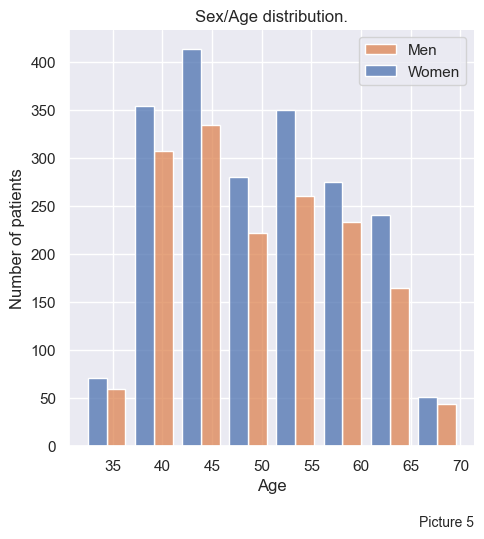

In [160]:
# Group df by bins of age starting from 35 to 70 with a step of 5 years and plot the count of people in each group
age_bins = np.arange(35, 75, 5).tolist()
df['age_bins'] = pd.cut(df['age'], bins=age_bins)
sns.displot(data=df, x='age', hue='male', kind='hist', bins=8, multiple='dodge', shrink=.8, legend=False)
plt.xticks(ticks=age_bins)
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.legend(['Men', 'Women'])
plt.title('Sex/Age distribution.')
grid_plots.annotate('Picture 5')
plt.show()
df.drop('age_bins', axis=1, inplace=True)

As was shown at the age/sex plot, women are just more prevalent in this data in general.

In [161]:
# Describe continuous features
df[continuous_cols].describe()

age   cigsPerDay      totChol        sysBP        diaBP  \
count  3656.000000  3656.000000  3656.000000  3656.000000  3656.000000   
mean     49.557440     9.022155   236.873085   132.368025    82.912062   
std       8.561133    11.918869    44.096223    22.092444    11.974825   
min      32.000000     0.000000   113.000000    83.500000    48.000000   
25%      42.000000     0.000000   206.000000   117.000000    75.000000   
50%      49.000000     0.000000   234.000000   128.000000    82.000000   
75%      56.000000    20.000000   263.250000   144.000000    90.000000   
max      70.000000    70.000000   600.000000   295.000000   142.500000   

               BMI    heartRate      glucose  
count  3656.000000  3656.000000  3656.000000  
mean     25.784185    75.730580    81.856127  
std       4.065913    11.982952    23.910128  
min      15.540000    44.000000    40.000000  
25%      23.080000    68.000000    71.000000  
50%      25.380000    75.000000    78.000000  
75%      28.040000    82.000000    87.000000  
max      56.800000   143.000000   394.000000

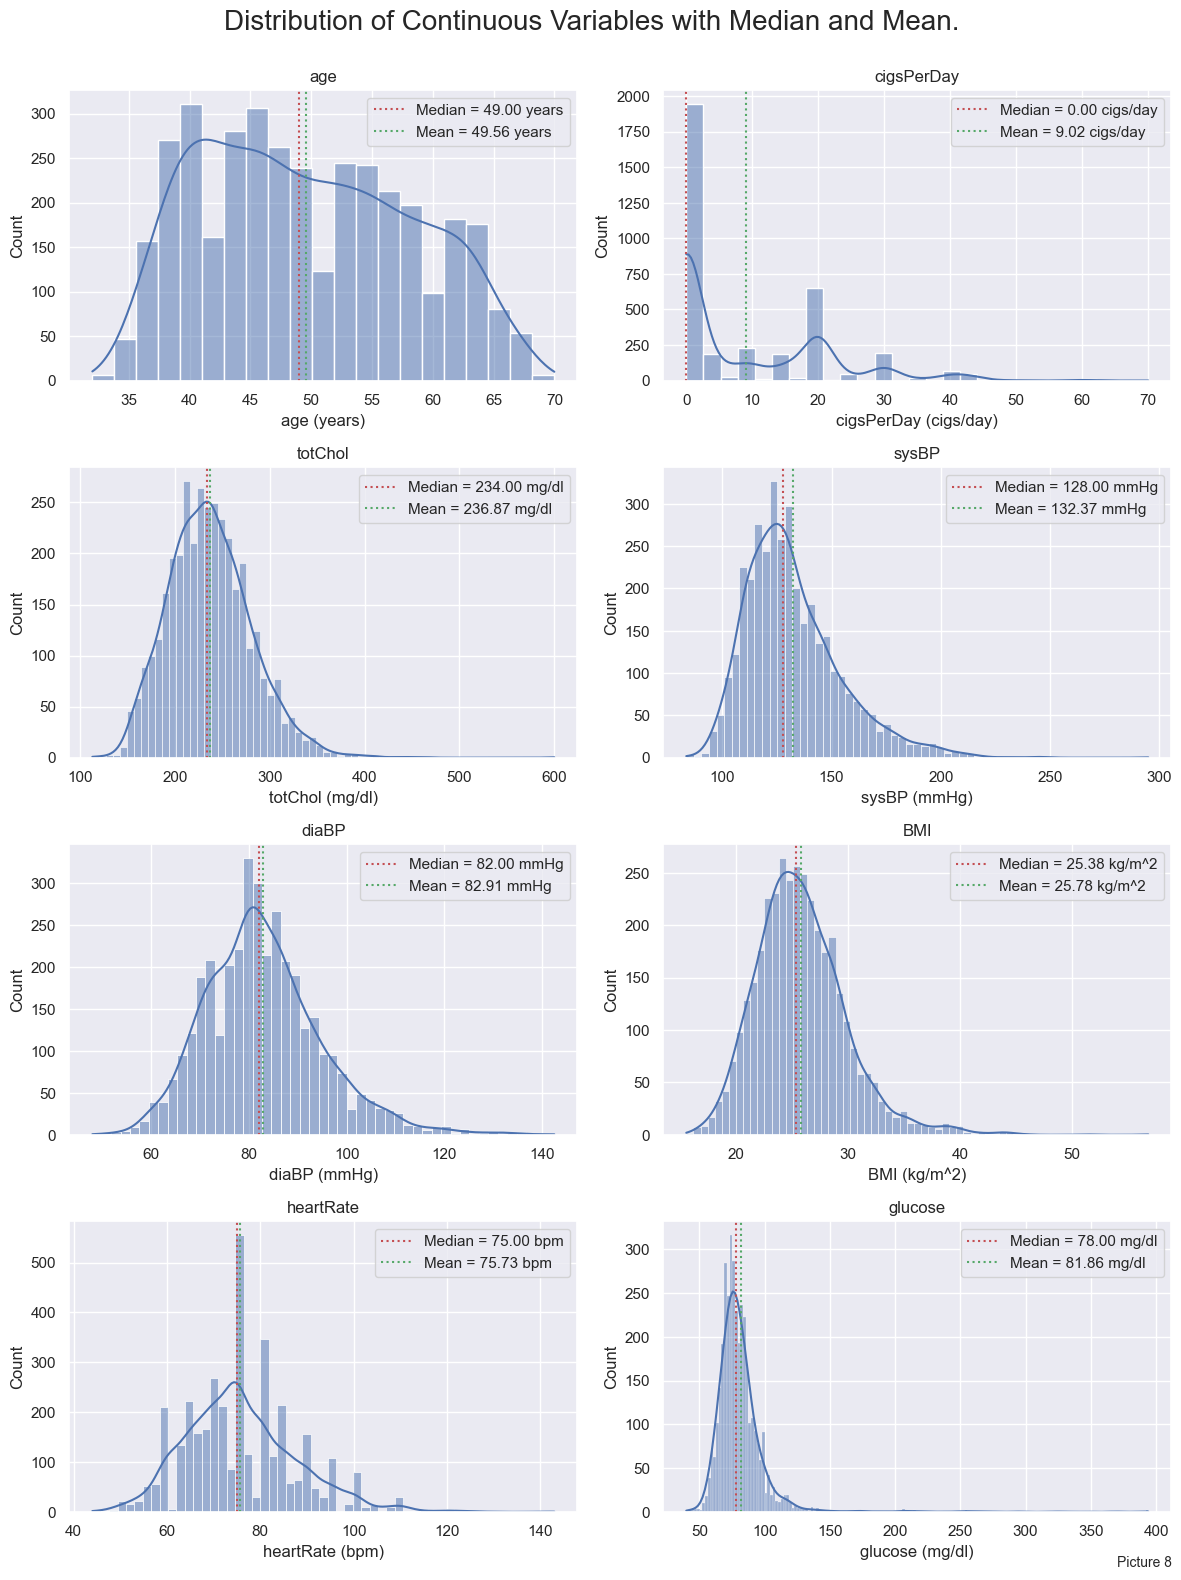

In [162]:
# Plot distributions of continuous variables
grid_plots.plot_grid_displots(data=df, columns=continuous_cols, units_list=cont_units, title='Distribution of Continuous Variables with Median and Mean.\n', annotation='Picture 8')

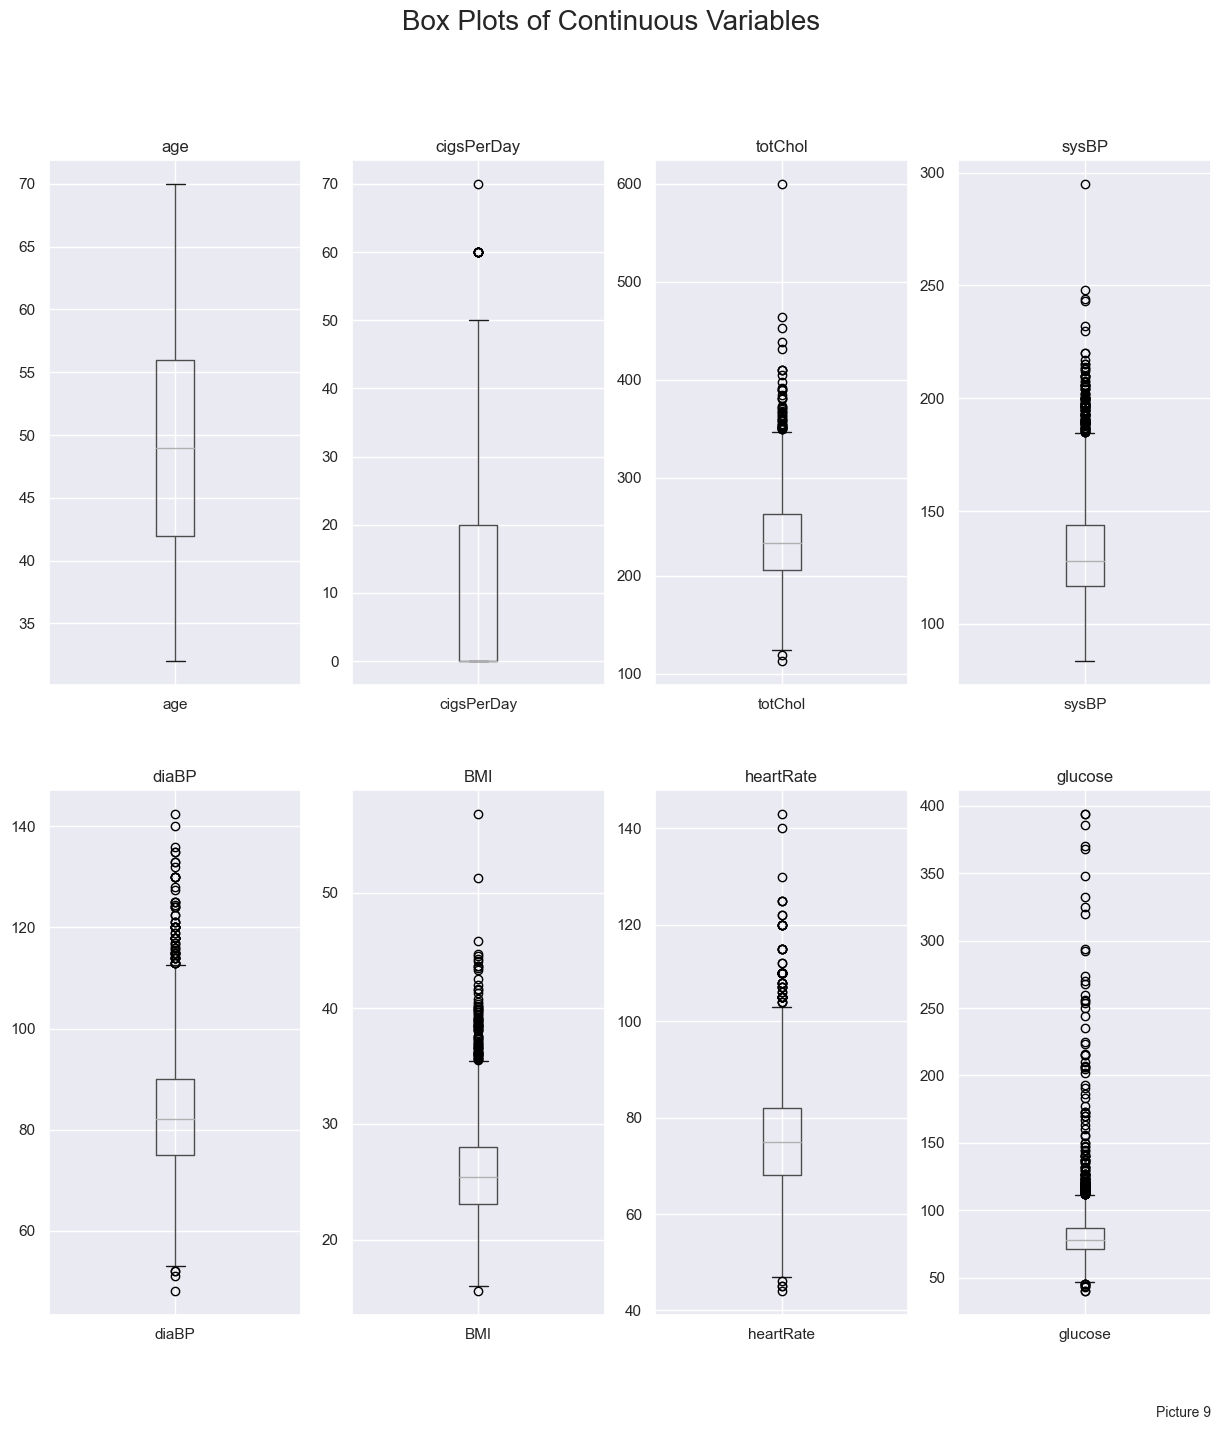

In [163]:
# Plot boxplots for continuous variables
grid_plots.plot_box_grid(data=df, cols=continuous_cols, annotation='Picture 9')

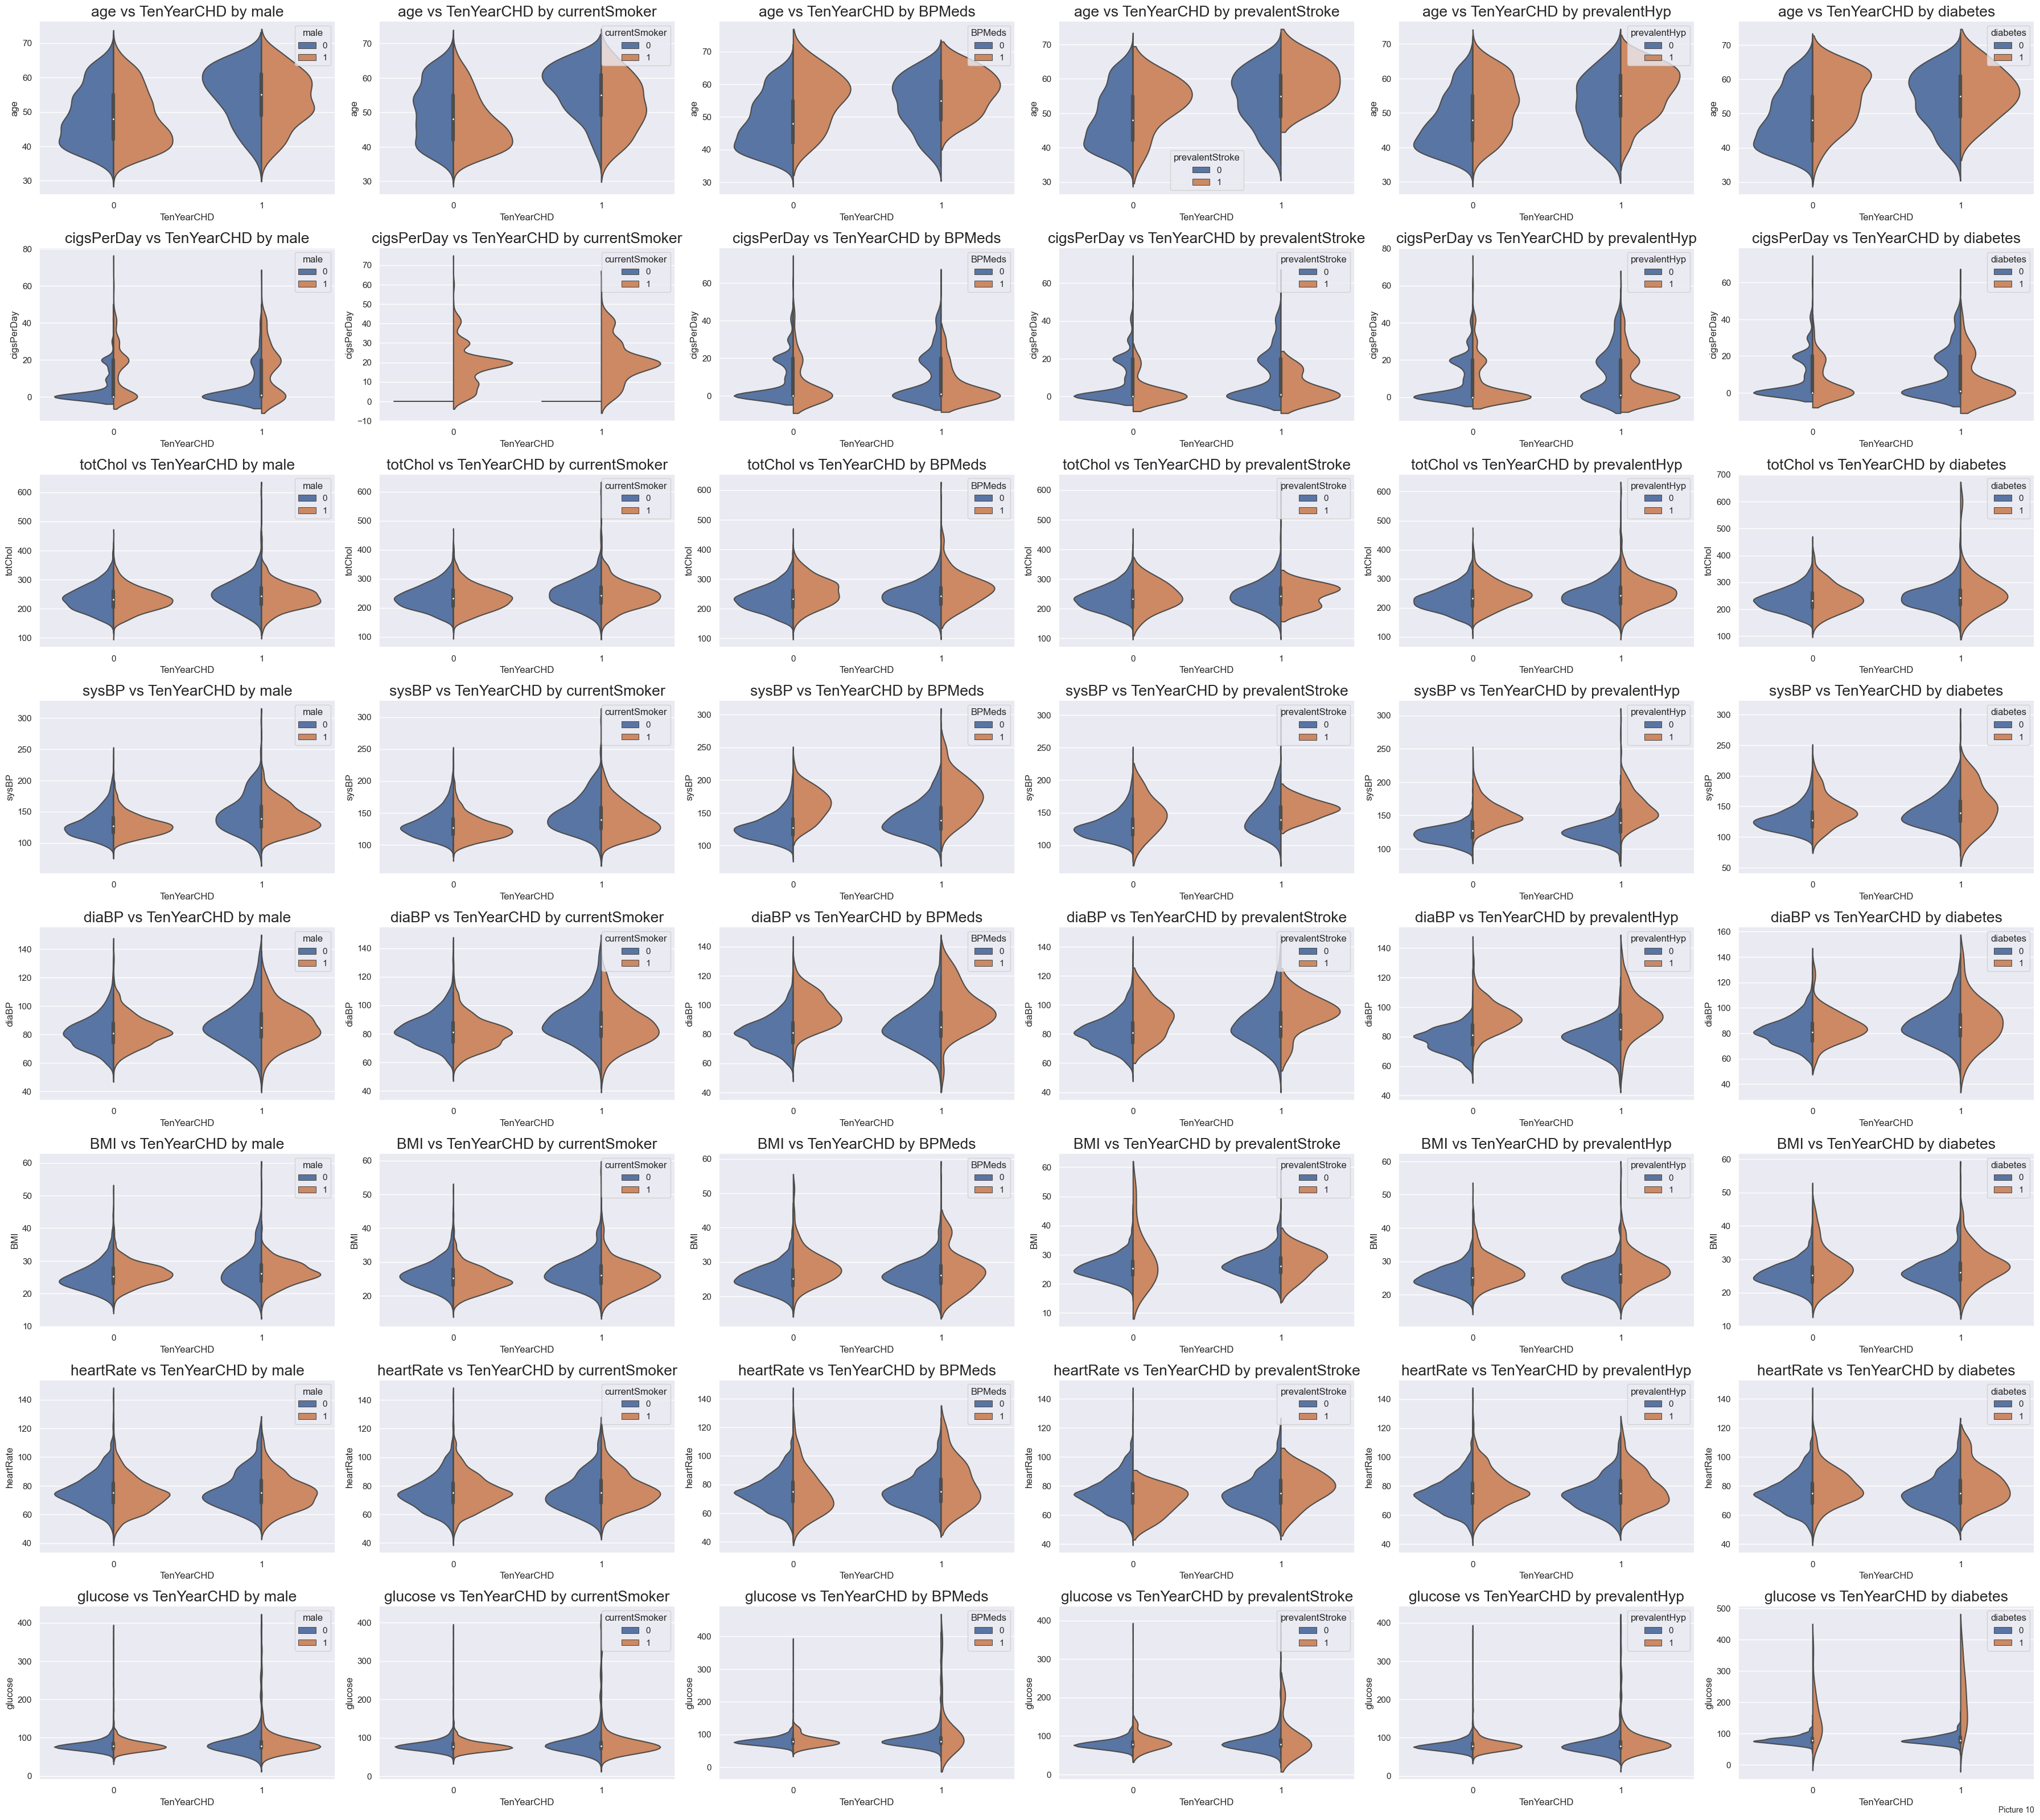

In [164]:
# Plot violin plots of continuous variables paired with bivariate categorical, including TenYearCHD

bivars = categorical_cols.copy()
bivars.remove('education')

grid_plots.plot_grid_violin(data=df, binom='TenYearCHD', continuous_vars=continuous_cols, binom_vars=bivars, annotation='Picture 10')

Summary
* Age is one of the strongest factors influencing the 10-year risk of CHD.
* As well as being male.
* Smoking also contributes to 10-year CHD. Number of cigarettes per day may also contribute to the increased risk.
* Blood pressure may also be contributing factor. Although, there is a certain hypo-diagnosis of diabetes in this population. So we might need to categorize glucose values into the stages of hyperglycemia.

Side notes: Many features have interesting but expected behaviors, shifting distributions if they are present:
* Blood pressures tend to be higher in patients that are taking BP medications. Also, patients with higher BP tend to be already taking BP meds.
* Diabetes flattens some distributions (except BMI, which is interesting, because higher BMI values tend to contribute to diabetes in patients)

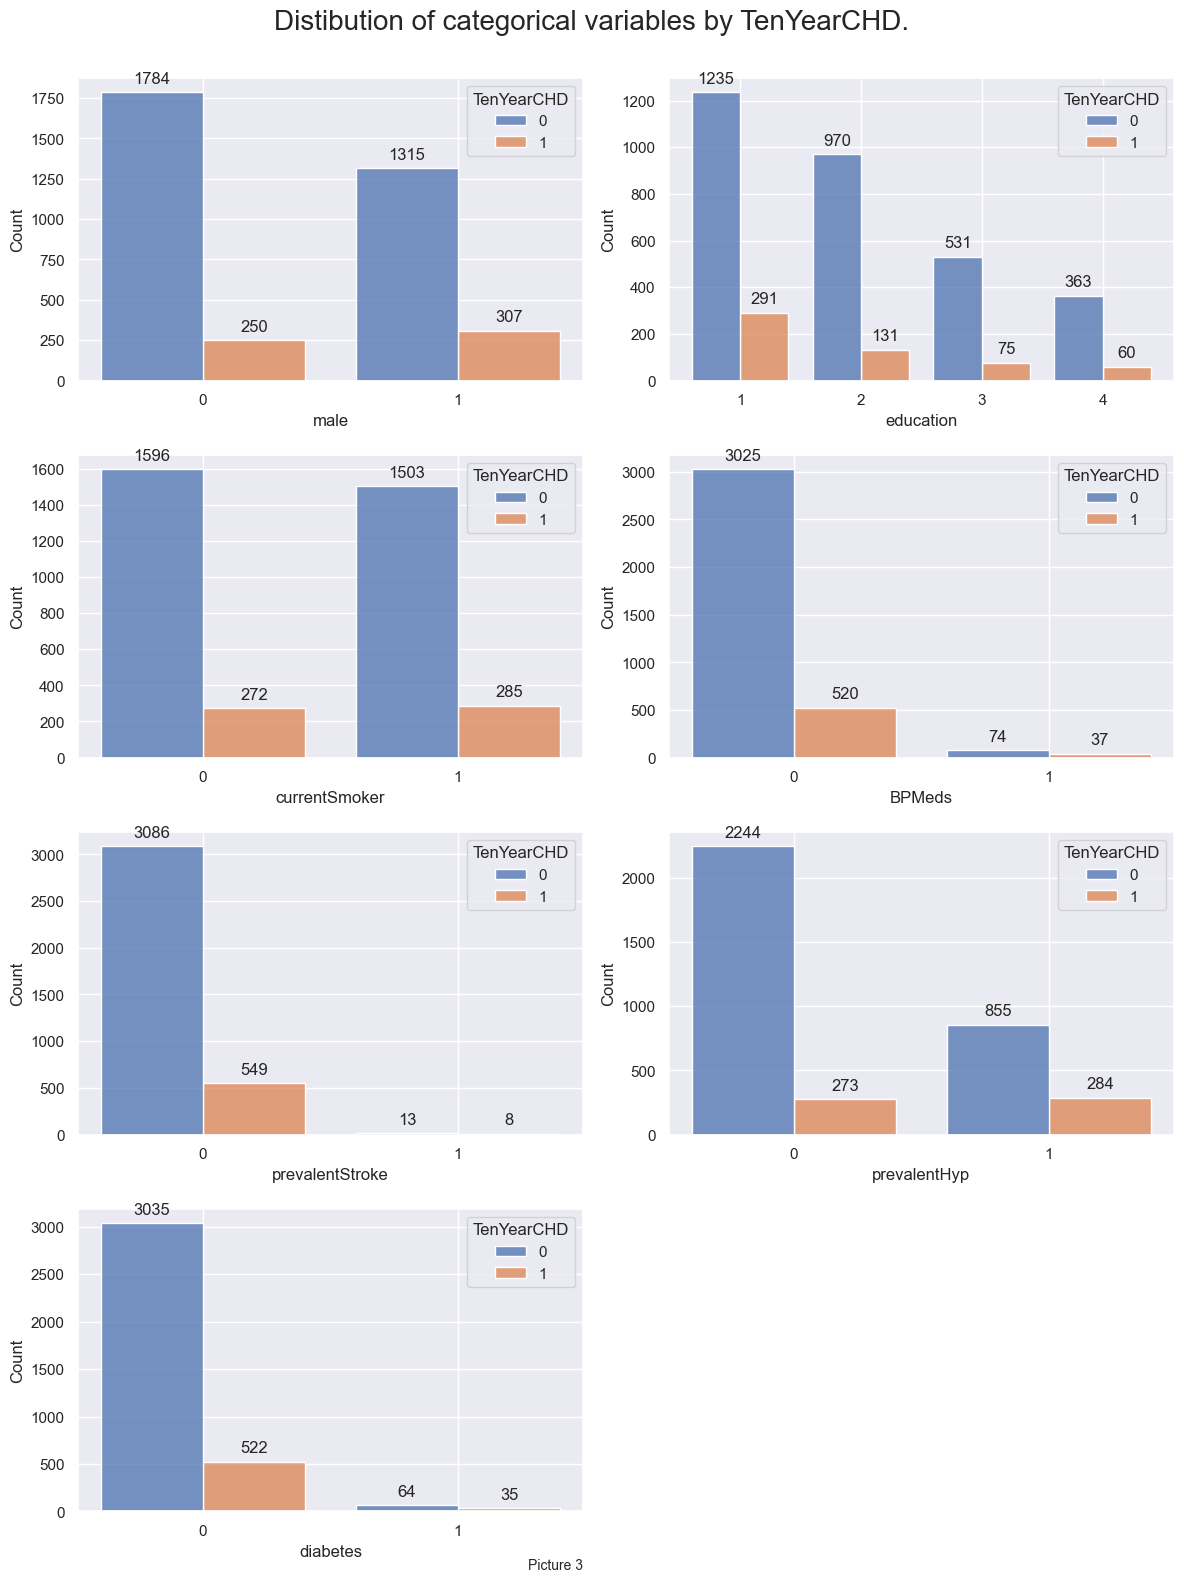

In [165]:
# Call function to draw barplots of the categorical values, groupped by TenYearCHD
grid_plots.plot_grid_bar(data=df, columns=categorical_cols, by='TenYearCHD', title="Distibution of categorical variables by TenYearCHD.\n", annotation='Picture 3')

Target value categorical influencers.
1. As was described before, being male seems to increase the risk.
2. Education does not seem to have any influence of target value.
3. Being a smoker increases the risk, but not much really.
4. BP Medications, Prevalent Stroke and Diabetes have not enough positive entries to draw any reasonable conclusion (might need to engineer new features in these categories).
5. Prevalent hypertension, although being quite disbalanced, seems to play a role in increasing the risk (might also engineer a new feature for this category).

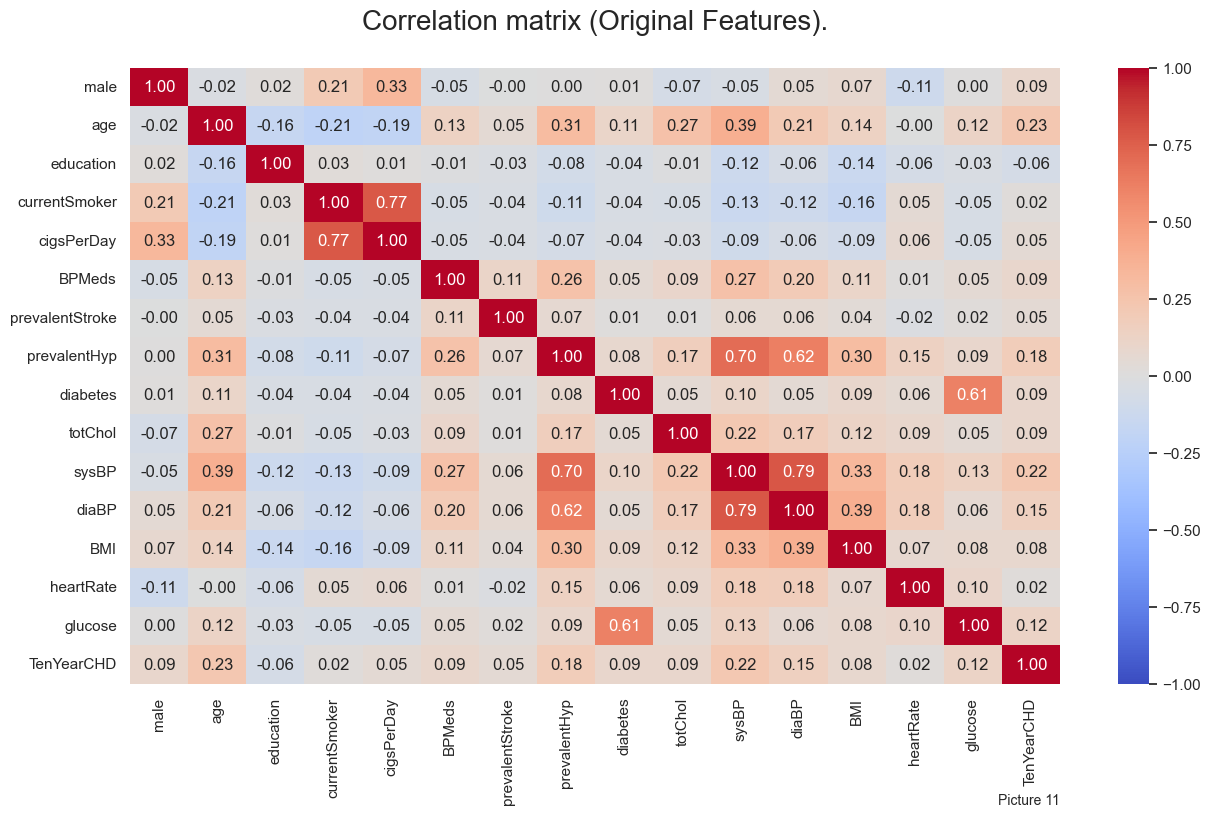

In [166]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation matrix (Original Features).\n', fontsize=20)
grid_plots.annotate('Picture 11');

We see that there are multiple collinear variables:
- diabetes and glucose
- currentSmoker and cigsPerDay
- prevalentHyp and sysBP, diaBP
    - sysBP and diaBP

Let's address this collinearity.

Let's introduce new column with a diagnosis of Diabetes, which we will calculate based on the levels of blood glucose.

In [167]:
# Assuming that fasting blood glucose level needed to diagnose Diabetes is at least 126 mg/dL, create a column with 1 or 0 for diabetes diagnosis. (We are making approximation heer, as the gold standard for DM diagnosis is two separate tests, oral glucose tolerance test or HbA1c test).

# Function to create diabetes_calc column based on 'glucose' level
def classify_col_1_0(data, cont_col, class_col, cutoff):
    data[class_col] = 0
    data.loc[data[cont_col] >= cutoff, class_col] = 1

In [168]:
# Call function and compare columns
classify_col_1_0(data=df, 
                cont_col='glucose',
                class_col='diabetes_1_0',
                cutoff=126)

print(f'Diabetes from original data: {df["diabetes"].value_counts()[0]}\n'
        f'Diabetes calculated in new set: {df["diabetes_1_0"].value_counts()[0]}')

Diabetes from original data: 3557
Diabetes calculated in new set: 3576


Well, not much of a difference. We are off by only few patients.
Let's try to divide diabetes by stages per CDC classification:
* Normal: < 100 mg/dl
* Pre-diabetes: 100 to 125 mg/dl
* Diabetes: > 125 mg/dl

This will also help address all the glucose level outliers we have.

In [169]:
# Function to classify continuous column into 3 classes
def classify_col_by_3(data, cont_col, class_col, cutoff1, cutoff2):
    data[class_col] = 0
    data.loc[data[cont_col] < cutoff1, class_col] = 0
    data.loc[(data[cont_col] >= cutoff1) & (data[cont_col] < cutoff2), class_col] = 1
    data.loc[data[cont_col] >= cutoff2, class_col] = 2

In [170]:
# Call function over the glucose column
classify_col_by_3(data=df, 
                cont_col='glucose',
                class_col='diabetes_stage',
                cutoff1=100,
                cutoff2=126)

In [171]:
df[['glucose', 'diabetes_stage']].groupby('diabetes_stage').count()

glucose
diabetes_stage         
0                  3317
1                   259
2                    80

This reduces the number of 'normal' glucose tests and also helps to stratify the abnormal glucose values a bit better. Let's compare the correlations. 

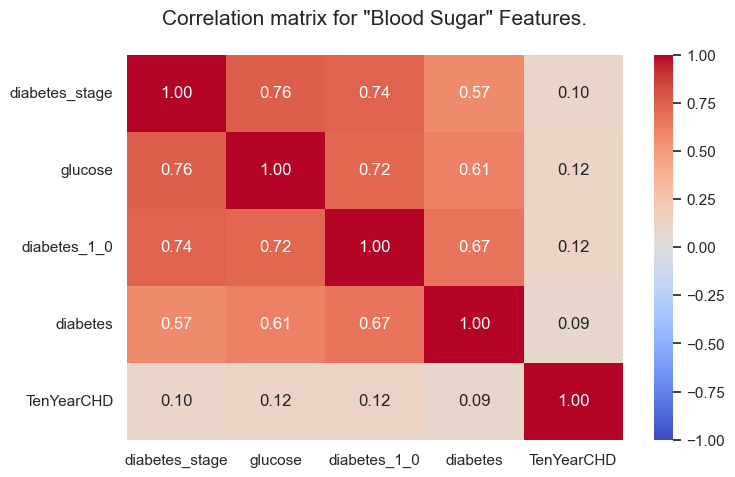

In [172]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['diabetes_stage', 'glucose', 'diabetes_1_0', 'diabetes', 'TenYearCHD']].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation matrix for "Blood Sugar" Features.\n', fontsize=15);

Let's keep the `diabetes_stage` column and drop all others.

In [173]:
# Drop the original diabetes, glucose and diabetes_1_0 columns
df.drop(columns=['diabetes', 'glucose', 'diabetes_1_0'], inplace=True) 

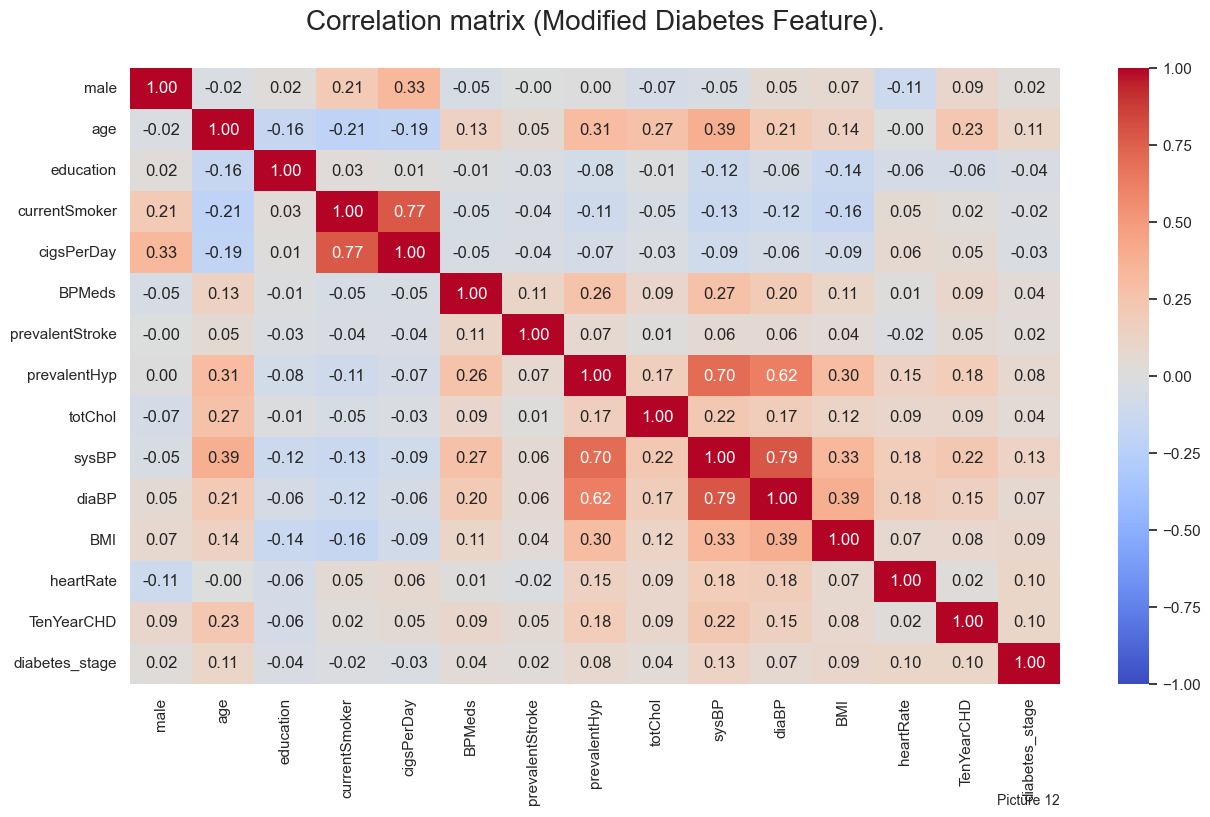

In [174]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation matrix (Modified Diabetes Feature).\n', fontsize=20)
grid_plots.annotate('Picture 12');

Let's move on to smoking.

In [175]:
df['currentSmoker'].value_counts()

currentSmoker
0    1868
1    1788
Name: count, dtype: int64

In [176]:
df['cigsPerDay'].value_counts()[:3]

cigsPerDay
0     1868
20     651
30     191
Name: count, dtype: int64

As expected all non-smokers have 0 cigsPerDay. So we can just drop the currentSmoker column.
Also, we can classify the cigsPerDay column.

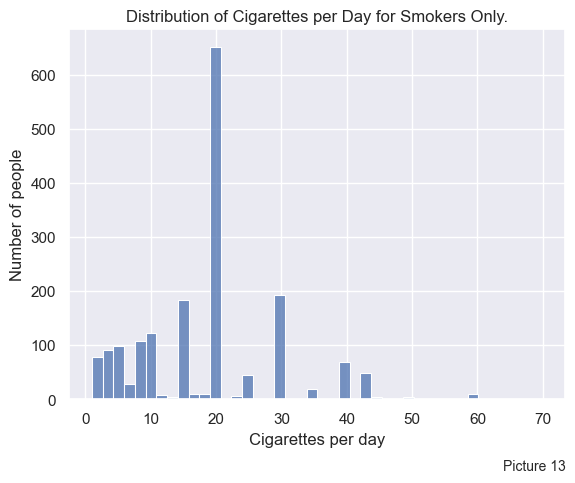

In [177]:
sns.histplot(data=df.loc[df['cigsPerDay'] > 0], x='cigsPerDay')
plt.title('Distribution of Cigarettes per Day for Smokers Only.')
plt.xlabel('Cigarettes per day')
plt.ylabel('Number of people')
grid_plots.annotate('Picture 13');

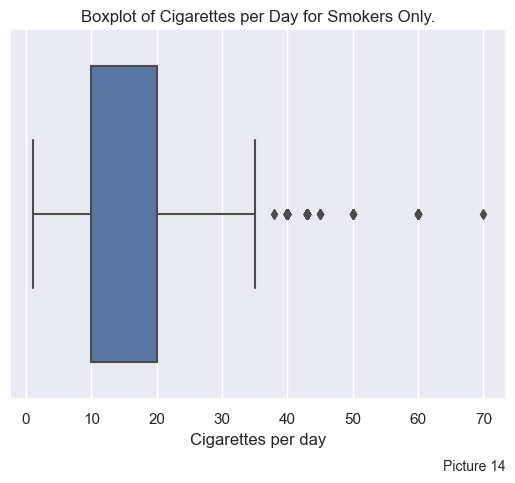

In [178]:
sns.boxplot(data=df.loc[df['cigsPerDay'] > 0], x='cigsPerDay')
plt.title('Boxplot of Cigarettes per Day for Smokers Only.')
plt.xlabel('Cigarettes per day')
grid_plots.annotate('Picture 14');

Many studies tend to classify cigarettes per day as follows:
- 0 cigs/day
- 1-10 cigs/day
- 11-20 cigs/day
- more than 20 cigs/day

This somewhat reflects our data. Also, this is going to be easier to interpret, as usual cigarette pack has 20 cigarettes. Hence, the classes would mean:
- Non-smoker
- Half a pack a day
- Pack a day
- More than a pack a day

Let's implement this.

In [179]:
# Function that classifies the cigsPerDay column into 4 classes
def classify_column(data, cont_col, class_col, cutoff_list):
    data[class_col] = 0
    for i, cutoff in enumerate(cutoff_list):
        data.loc[data[cont_col] > cutoff, class_col] = i + 1

In [180]:
# Call function over the cigsPerDay column
classify_column(data=df, 
                cont_col='cigsPerDay',
                class_col='smoker_class',
                cutoff_list=[0, 10, 20])

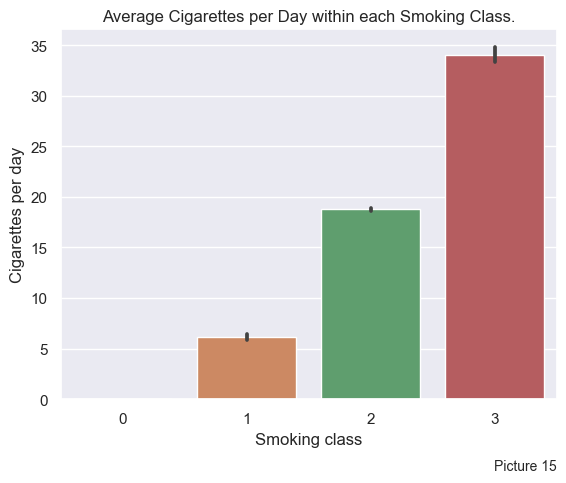

In [181]:
sns.barplot(data=df, x='smoker_class', y='cigsPerDay')
plt.title('Average Cigarettes per Day within each Smoking Class.')
plt.xlabel('Smoking class')
plt.ylabel('Cigarettes per day')
grid_plots.annotate('Picture 15');

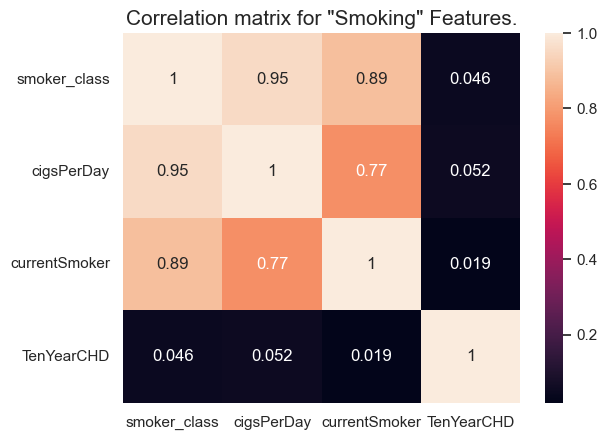

In [182]:
sns.heatmap(df[['smoker_class', 'cigsPerDay', 'currentSmoker', 'TenYearCHD']].corr(), annot=True)
plt.title('Correlation matrix for "Smoking" Features.', fontsize=15);

It seems like this column aggregates the best of two columns. Let's drop the old ones.

In [183]:
# Drop the original cigsPerDay and currentSmoker columns
df.drop(columns=['cigsPerDay', 'currentSmoker'], inplace=True)

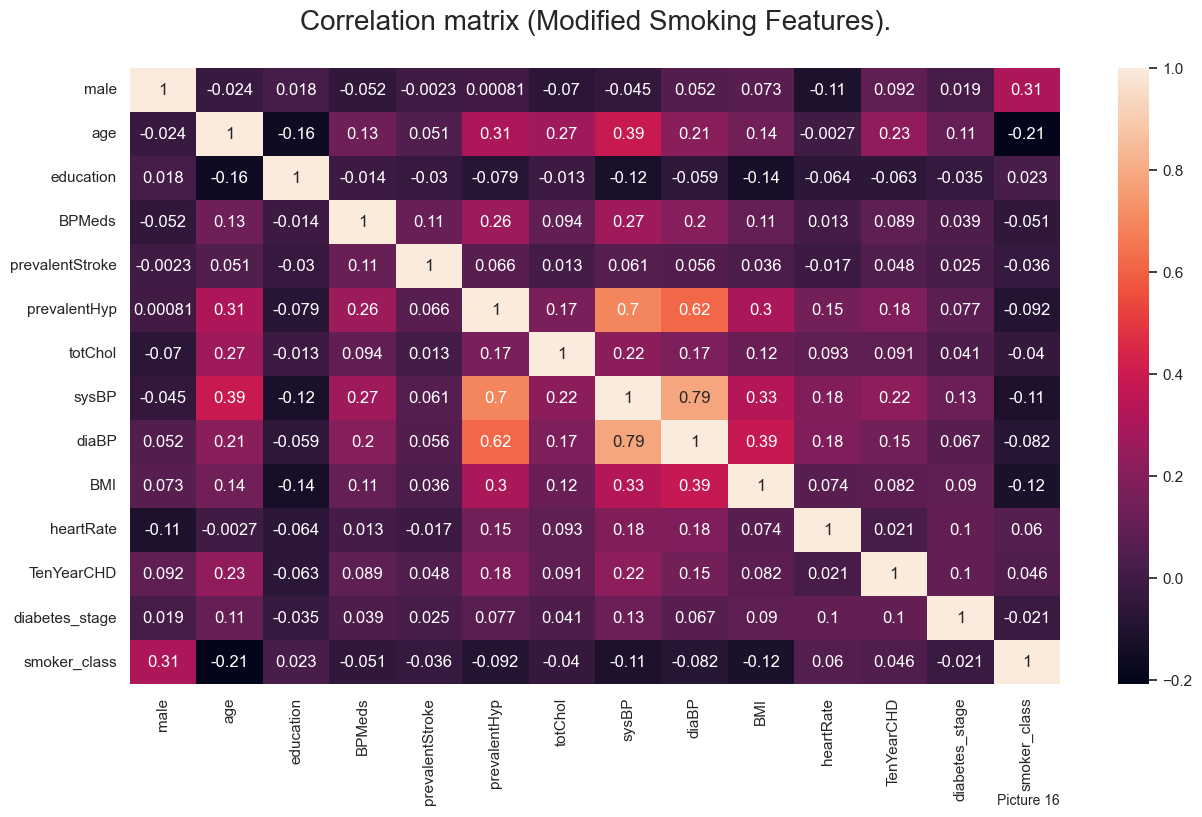

In [184]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation matrix (Modified Smoking Features).\n', fontsize=20)
grid_plots.annotate('Picture 16');

Let's move on to the blood pressure columns

For that we will need to combine systolic and diastolic blood pressures into one value. The most common way of doing that is by calculating the Mean Arterial Pressure (MAP).

$MAP = DP + (SP - DP)/3$

In [185]:
# Function to calculate the MAP (mean arterial pressure) from the systolic and diastolic blood pressure
def calculate_map(data, sys_col, dia_col, map_col):
    data[map_col] = ((data[sys_col] - data[dia_col]) / 3 + data[dia_col]).apply(lambda x: round(x, 2))

In [186]:
# Call function over the sysBP and diaBP columns
calculate_map(data=df, 
                sys_col='sysBP',
                dia_col='diaBP',
                map_col='MAP')

In [187]:
df[['sysBP', 'diaBP', 'MAP']].head()

sysBP  diaBP     MAP
0  106.0   70.0   82.00
1  121.0   81.0   94.33
2  127.5   80.0   95.83
3  150.0   95.0  113.33
4  130.0   84.0   99.33

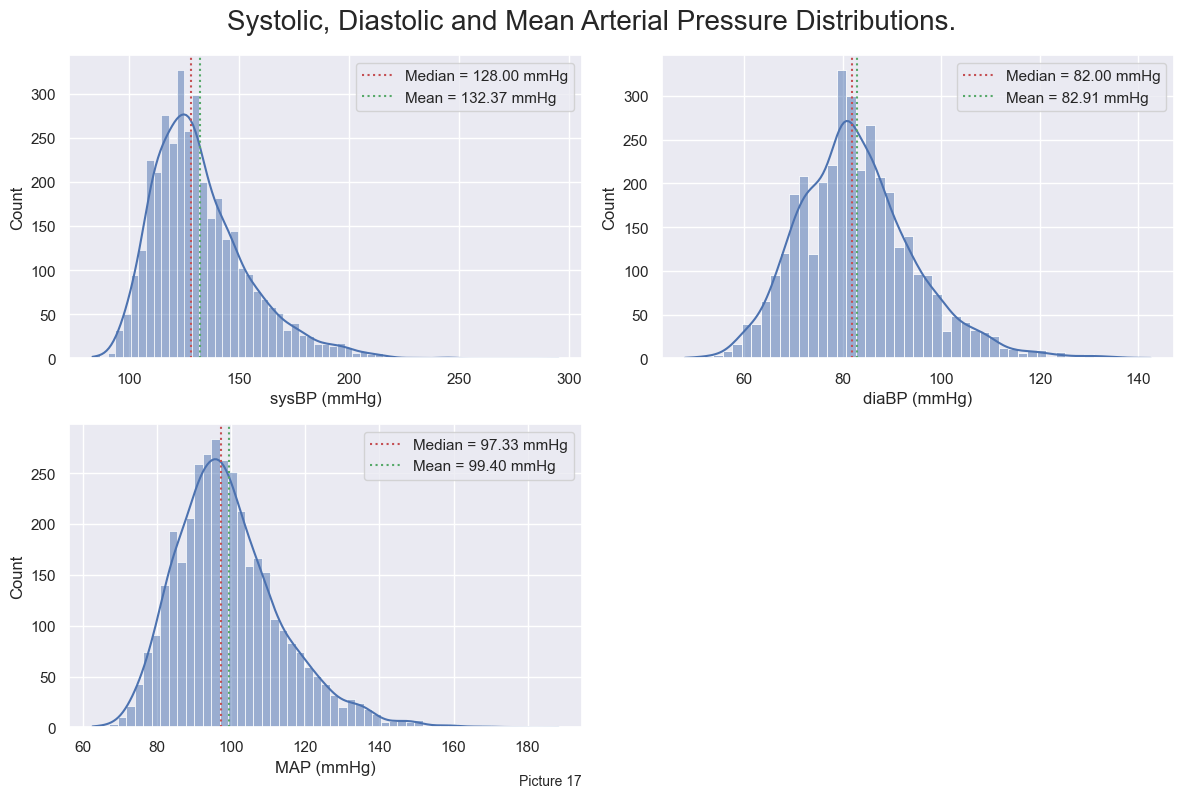

In [189]:
grid_plots.plot_grid_displots(data=df, columns=['sysBP', 'diaBP', 'MAP'], units_list=['mmHg', 'mmHg', 'mmHg'], title='Systolic, Diastolic and Mean Arterial Pressure Distributions.', show_titles=False, annotation='Picture 17');

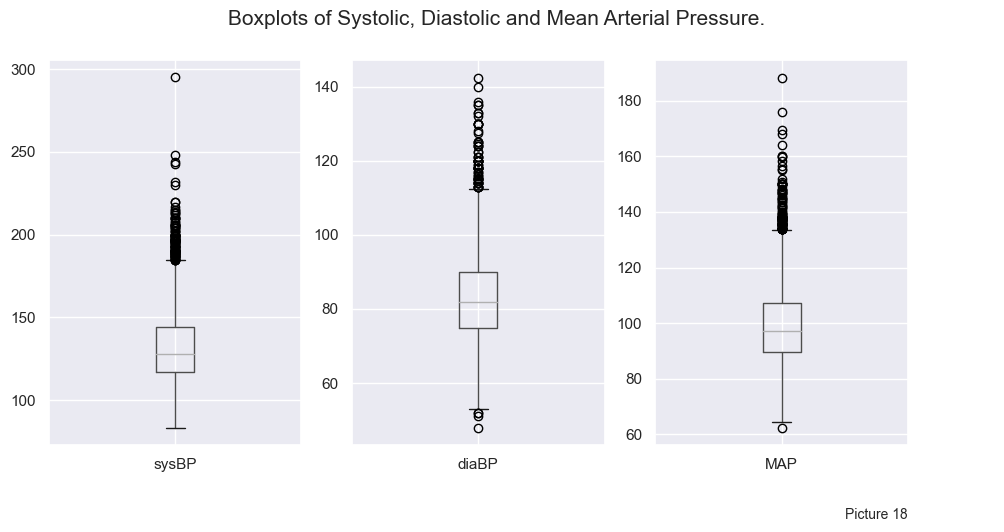

In [191]:
grid_plots.plot_box_grid(data=df, cols=['sysBP', 'diaBP', 'MAP'], figsize=(15,5), title='Boxplots of Systolic, Diastolic and Mean Arterial Pressure.'+' '*40, title_fontsize=15, show_titles=False, annotation='Picture 18');

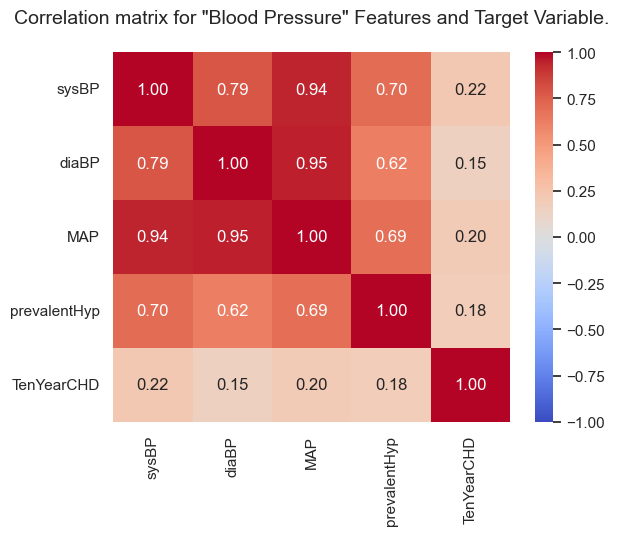

In [193]:
sns.heatmap(df[['sysBP', 'diaBP', 'MAP', 'prevalentHyp', 'TenYearCHD']].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation matrix for "Blood Pressure" Features and Target Variable.\n', fontsize=14);

We can remove sysBP and diaBP columns. Also, we can classify hypertension stages:

- Optimal MAP value: <93.33
- Normal MAP value: 93.33 – 99.00
- High normal value: 99.01 – 105.67
- Grade 1 hypertension: 105.68 – 119.00
- Grade 2 hypertension:119.01 – 132.33
- Grade 3 hypertension: ≥132.34

We will stratify our classes as follows:
0. Normal MAP: < 99
1. High normal MAP: 99.01 – 105.67
2. Grade 1 hypertension: 105.68 – 119.00
3. Grade 2 hypertension:119.01 – 132.33
4. Grade 3 hypertension: ≥132.34

In [194]:
# Compare prevalentHyp and MAP columns for normal blood pressure patients
df[df['MAP'] < 105.68]['MAP'].count(), df[(df['prevalentHyp'] == 0)]['prevalentHyp'].count()

(2641, 2517)

This approximates the values we have in the `prevalentHyp` column pretty good.

In [195]:
map_htn_cutoffs = [105.67, 119.0, 132.33]

# Call classify_column function over the MAP column
classify_column(data=df, 
                cont_col='MAP',
                class_col='hypertension_stage',
                cutoff_list=map_htn_cutoffs)

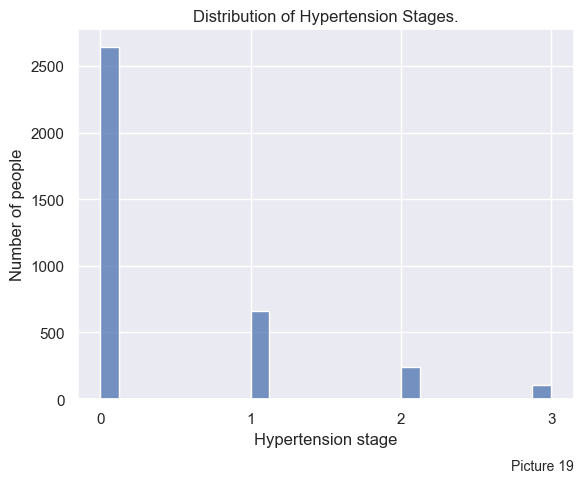

In [197]:
sns.histplot(data=df, x='hypertension_stage')
plt.xticks(ticks=[0, 1, 2, 3])
plt.title('Distribution of Hypertension Stages.')
plt.xlabel('Hypertension stage')
plt.ylabel('Number of people')
grid_plots.annotate('Picture 19');

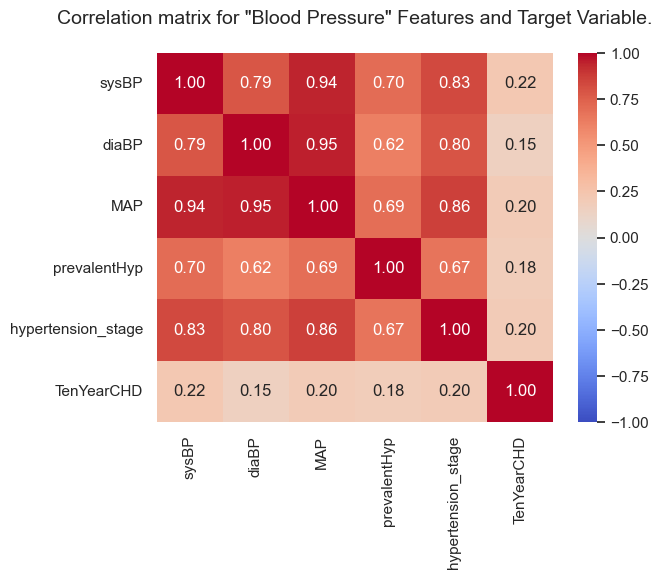

In [198]:
sns.heatmap(df[['sysBP', 'diaBP', 'MAP', 'prevalentHyp', 'hypertension_stage', 'TenYearCHD']].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation matrix for "Blood Pressure" Features and Target Variable.\n', fontsize=14);

In [199]:
# Drop the original sysBP and diaBP columns and the prevalentHyp column
df.drop(columns=['sysBP', 'diaBP', 'prevalentHyp'], inplace=True)

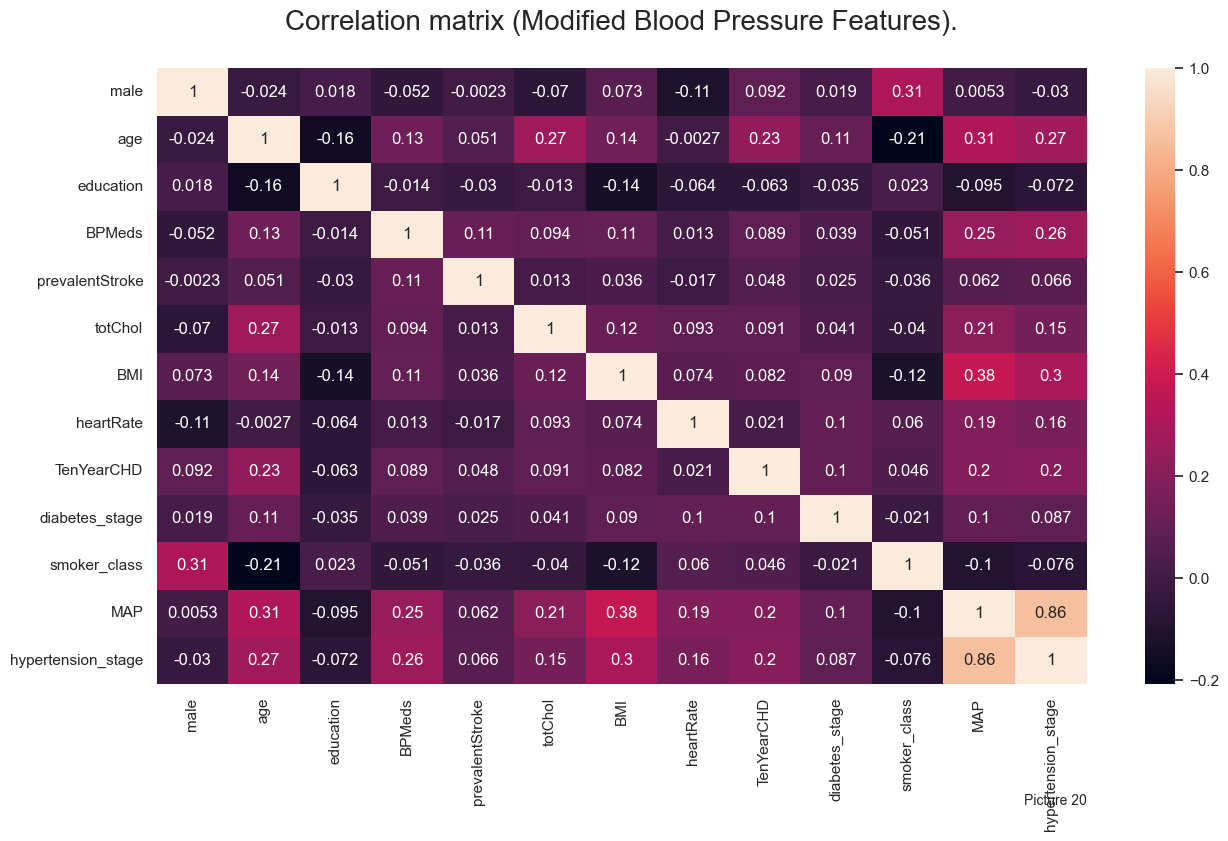

In [201]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation matrix (Modified Blood Pressure Features).\n', fontsize=20)
grid_plots.annotate('Picture 20');

We will leave both MAP and hypertension_stage columns for now.

In [64]:
# Export the data to a new csv file
export_path = '../data/interim/'
sb_utils.save_file(df, fname='data_drop_eda.csv', dname=export_path)

A file already exists with this name.


Please re-run this cell with a new filename.


#### Let's do all these manipulations for the imputed dataset now.

In [65]:
df = df_imp

# Classify the glucose column  into 3 diabetes stages
classify_col_by_3(data=df, 
                cont_col='glucose',
                class_col='diabetes_stage',
                cutoff1=100,
                cutoff2=126)


# Classify the cigsPerDay column
classify_column(data=df, 
                cont_col='cigsPerDay',
                class_col='smoker_class',
                cutoff_list=[0, 10, 20])

# Call function over the sysBP and diaBP columns to create MAP column
calculate_map(data=df, 
                sys_col='sysBP',
                dia_col='diaBP',
                map_col='MAP')

# Call classify_column function over the MAP column to create hypertension_stage column
classify_column(data=df, 
                cont_col='MAP',
                class_col='hypertension_stage',
                cutoff_list=map_htn_cutoffs)

# Drop the original diabetes, glucose, cigsPerDay, currentSmoker, 'sysBP', 'diaBP', 'prevalentHyp' columns
df.drop(columns=['diabetes', 'glucose', 'cigsPerDay', 'currentSmoker', 'sysBP', 'diaBP', 'prevalentHyp'], inplace=True)

In [66]:
# Export the data to a new csv file
sb_utils.save_file(df, fname='data_imput_eda.csv', dname=export_path)

A file already exists with this name.


Please re-run this cell with a new filename.
